In [1]:
#@title Setup and imports

import os
import random
from collections import defaultdict
from math import log2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [2]:
#@title Download MovieLens-100k

DATA_DIR = "ml-100k"
DATA_PATH = os.path.join(DATA_DIR, "u.data")

if not os.path.exists(DATA_DIR):
  !wget -q https://files.grouplens.org/datasets/movielens/ml-100k.zip
  !unzip -q ml-100k.zip
  !rm ml-100k.zip



In [3]:
MIN_USER_RATINGS = 5

df = pd.read_csv(
    DATA_PATH,
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"],
    )

# Filter users with at least MIN_USER_RATINGS
counts = df["user_id"].value_counts()
print("Total users = ", len(counts))
keep_users = counts[counts >= MIN_USER_RATINGS].index
print("Filtered users = ", len(keep_users))

# update df to only keep filtered users
df = df[df["user_id"].isin(keep_users)].copy()
df.head()

Total users =  943
Filtered users =  943


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
#@title Map sample ids from 0 to len - 1

user_id_map = {u: idx for idx, u in enumerate(sorted(df["user_id"].unique()))}
item_id_map = {i: idx for idx, i in enumerate(sorted(df["item_id"].unique()))}

df["uid"] = df["user_id"].map(user_id_map)
df["iid"] = df["item_id"].map(item_id_map)

# overwrite df to be correct format
df = df[["uid", "iid", "rating"]]

df.head()

,uid,iid,rating
0,195,241,3
1,185,301,3
2,21,376,1
3,243,50,2
4,165,345,1


In [5]:
#@title Create train/val/test splits

n_users = df["uid"].nunique()
n_items = df["iid"].nunique()

# Build per-user rating list. user_ratings is a dict with uid as keys and list
# of movie, rating pairs as values
user_ratings = defaultdict(list)
for row in df.itertuples(index=False):
  user_ratings[row.uid].append((row.iid, float(row.rating)))

# Train/val/test: per user -> 1 test, 1 val, rest train
train_data = []
val_items = {}
test_items = {}
full_ratings_per_user = {}

# for every user, get a test item, val item and train list. items is a list of
# movie id and rating pairs
for u, items in user_ratings.items():
  random.shuffle(items)
  test_items[u] = items[0]
  val_items[u] = items[1]
  train_items = items[2:]
  full_ratings_per_user[u] = items

    # build training set
  for iid, r in train_items:
    train_data.append((u, iid, r))

# build df for training
train_df = pd.DataFrame(train_data, columns=["uid", "iid", "rating"])
print("Training set size:", len(train_df))


Training set size: 98114


In [6]:
#@title Build positive and negative pools for BPR-style sampling

all_items = set(range(n_items))
user_pos_items = defaultdict(list)   # items with rating >= 4
user_neg_items = defaultdict(list)   # low-rated + unrated
user_item_rating = defaultdict(dict) # rating lookup

# build up user item rating dict for all rated items in train set. Also
# build pos items dict for every user
for row in train_df.itertuples(index=False):
  u, i, r = int(row.uid), int(row.iid), float(row.rating)
  user_item_rating[u][i] = r
  if r >= 4.0:
    user_pos_items[u].append(i)

# build neg items list for each user by getting both low rated and unrated items
# list for all
for u in range(n_users):
  rated_items = set(user_item_rating[u].keys())
  low_rated = [i for i, r in user_item_rating[u].items() if r <= 3.0]
  unrated = list(all_items - rated_items)
  user_neg_items[u] = low_rated + unrated

valid_users = [u for u in range(n_users) if len(user_pos_items[u]) > 0]
print("Users with at least one positive (>=4):", len(valid_users))


Users with at least one positive (>=4): 942


In [7]:
from types import LambdaType
#@title Define model and sampling functions

# Hyperparameters
EMBED_DIM = 64
LR = 1e-3
LAMBDA_REG = 1e-4
WEIGHT_DECAY = 1e-5
EPOCHS = 15
BATCH_SIZE = 2048
NEG_PER_POS = 3
TOP_K = 10

class MF_BPR(nn.Module):
  def __init__(self, n_users, n_items, embed_dim):
    super().__init__()
    self.user_emb = nn.Embedding(n_users, embed_dim)
    self.item_emb = nn.Embedding(n_items, embed_dim)
    nn.init.normal_(self.user_emb.weight, std=0.01)
    nn.init.normal_(self.item_emb.weight, std=0.01)

  def forward(self, users, pos_items, neg_items):
    u_vec = self.user_emb(users)
    i_vec = self.item_emb(pos_items)
    j_vec = self.item_emb(neg_items)
    s_ui = (u_vec * i_vec).sum(dim=1)
    s_uj = (u_vec * j_vec).sum(dim=1)
    return s_ui, s_uj

  def score_all_items(self):
    return self.user_emb.weight @ self.item_emb.weight.t()

def sample_batch(model_type, batch_size):
  """
  Returns (users, pos_items, neg_items, w_ij, pweight_ui).

  model_type:
    - "bpr"        -> w_ij = 1
    - "graded_bpr" -> w_ij = |r_ui - r_uj|
    - "bpr_pp"     -> positives sampled w.r.t rating. Unweighted loss
  """
  users = []
  pos_items = []
  neg_items = []
  weights = []
  pweights_ui = []   # rating-based weight for BPR++

  for _ in range(batch_size):
    u = random.choice(valid_users)

    pos_pool = user_pos_items[u]
    if len(pos_pool) == 0:
      continue


    if model_type == "bpr_pp":
      # bias positive sampling by rating magnitude
      ratings = np.array([user_item_rating[u][i] for i in pos_pool], dtype=float)
      probs = ratings / ratings.sum()
      i = int(np.random.choice(pos_pool, p=probs))
      pweight = user_item_rating[u][i]
    else:
      # unbiased sampling for standard and graded bpr
      i = random.choice(pos_pool)
      pweight = 1.0

    neg_pool = user_neg_items[u]
    if len(neg_pool) == 0:
      continue
    j = random.choice(neg_pool)

    r_ui = user_item_rating[u].get(i, 0.0)
    r_uj = user_item_rating[u].get(j, 0.0)

    if model_type == "graded_bpr":
      w_ij = abs(r_ui - r_uj)
      if w_ij == 0:
        w_ij = 1.0
    else:
      w_ij = 1.0

    users.append(u)
    pos_items.append(i)
    neg_items.append(j)
    weights.append(w_ij)
    pweights_ui.append(pweight)

  return (
      torch.LongTensor(users).to(DEVICE),
      torch.LongTensor(pos_items).to(DEVICE),
      torch.LongTensor(neg_items).to(DEVICE),
      torch.FloatTensor(weights).to(DEVICE),
      torch.FloatTensor(pweights_ui).to(DEVICE),
      )


In [8]:
#@title Training loop

def train_model(model_type):
  """
  model_type in {"bpr", "graded_bpr", "bpr_pp"}
  """
  print(f"\n=== Training {model_type} ===")
  model = MF_BPR(n_users, n_items, EMBED_DIM).to(DEVICE)
  optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

  n_steps = (len(train_df) // BATCH_SIZE) + 1

  for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for _ in range(n_steps):
      users, pos_items, neg_items, w_ij, pweight_ui = sample_batch(
          model_type, BATCH_SIZE
          )
      if users.numel() == 0:
        continue

      s_ui, s_uj = model(users, pos_items, neg_items)
      x_uij = s_ui - s_uj
      log_sig = torch.log(torch.sigmoid(x_uij) + 1e-8)

      if model_type == "graded_bpr":
        loss = -(w_ij * log_sig).mean()
      else:
        loss = -log_sig.mean()

      reg = (
          model.user_emb(users).pow(2).sum() +
          model.item_emb(pos_items).pow(2).sum() +
          model.item_emb(neg_items).pow(2).sum()
          ) * LAMBDA_REG

      loss = loss + reg
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss / max(1,n_steps):.4f}")

  return model


In [9]:
#@title Evaluation metrics: Top-K and Spearman rank correlation

def evaluate_topk(model, k=TOP_K):
    model.eval()
    with torch.no_grad():
        score_matrix = model.score_all_items().cpu().numpy()

    hits, ndcgs = [], []

    for u in range(n_users):
        test_i, _ = test_items[u]
        scores = score_matrix[u].copy()

        # mask all rated items except the test item
        for iid, _r in full_ratings_per_user[u]:
            if iid != test_i:
                scores[iid] = -1e9

        # top-k indices
        topk_idx = np.argpartition(scores, -k)[-k:]
        topk_idx = topk_idx[np.argsort(-scores[topk_idx])]

        if test_i in topk_idx:
            hits.append(1.0)
            rank = np.where(topk_idx == test_i)[0][0] + 1
            ndcgs.append(1.0 / log2(rank + 1))
        else:
            hits.append(0.0)
            ndcgs.append(0.0)

    return float(np.mean(hits)), float(np.mean(ndcgs))


def spearman_correlation(model):
    model.eval()
    with torch.no_grad():
        score_matrix = model.score_all_items().cpu().numpy()

    def spearman(x, y):
        x = np.asarray(x)
        y = np.asarray(y)
        # rank (approximate; higher score -> lower rank index)
        rx = np.argsort(np.argsort(-x)).astype(float)
        ry = np.argsort(np.argsort(-y)).astype(float)
        rx = (rx - rx.mean()) / (rx.std() + 1e-8)
        ry = (ry - ry.mean()) / (ry.std() + 1e-8)
        return float(np.mean(rx * ry))

    rhos = []
    for u in range(n_users):
        items, ratings = zip(*full_ratings_per_user[u])
        if len(items) < 2:
            continue
        scores = score_matrix[u, list(items)]
        rhos.append(spearman(scores, ratings))

    return float(np.mean(rhos))


In [10]:
#@title Train BPR, Graded BPR, BPR++ and show results

results = {}

for model_type in ["bpr", "graded_bpr", "bpr_pp"]:
    model = train_model(model_type)
    hr, ndcg = evaluate_topk(model)
    rho = spearman_correlation(model)
    results[model_type] = {"HitRate@10": hr, "NDCG@10": ndcg, "Spearman": rho}
    print(
        f"\n{model_type}: "
        f"HitRate@10={hr:.4f}, NDCG@10={ndcg:.4f}, Spearman={rho:.4f}"
    )

print("\n=== Summary ===")
for model_type, metrics in results.items():
    print(model_type, ":", metrics)



=== Training bpr ===
Epoch 1/15 - Loss: 0.6938
Epoch 2/15 - Loss: 0.6931
Epoch 3/15 - Loss: 0.6930
Epoch 4/15 - Loss: 0.6911
Epoch 5/15 - Loss: 0.6875
Epoch 6/15 - Loss: 0.6858
Epoch 7/15 - Loss: 0.6857
Epoch 8/15 - Loss: 0.6854
Epoch 9/15 - Loss: 0.6853
Epoch 10/15 - Loss: 0.6857
Epoch 11/15 - Loss: 0.6854
Epoch 12/15 - Loss: 0.6859
Epoch 13/15 - Loss: 0.6856
Epoch 14/15 - Loss: 0.6853
Epoch 15/15 - Loss: 0.6854

bpr: HitRate@10=0.1283, NDCG@10=0.0680, Spearman=0.2182

=== Training graded_bpr ===
Epoch 1/15 - Loss: 2.9799
Epoch 2/15 - Loss: 2.8495
Epoch 3/15 - Loss: 2.3248
Epoch 4/15 - Loss: 1.9894
Epoch 5/15 - Loss: 1.9276
Epoch 6/15 - Loss: 1.9080
Epoch 7/15 - Loss: 1.8948
Epoch 8/15 - Loss: 1.8970
Epoch 9/15 - Loss: 1.8914
Epoch 10/15 - Loss: 1.8776
Epoch 11/15 - Loss: 1.8799
Epoch 12/15 - Loss: 1.8807
Epoch 13/15 - Loss: 1.8725
Epoch 14/15 - Loss: 1.8656
Epoch 15/15 - Loss: 1.8621

graded_bpr: HitRate@10=0.1888, NDCG@10=0.1025, Spearman=0.2617

=== Training bpr_pp ===
Epoch 1/15 

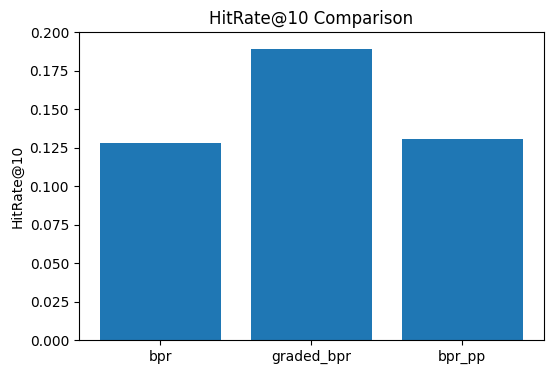

In [16]:
import matplotlib.pyplot as plt
df_results = pd.DataFrame(results).T  # models as rows
df_results.index.name = "Model"


models = list(results.keys())
hit_rates = [results[m]["HitRate@10"] for m in models]

plt.figure(figsize=(6,4))
plt.bar(models, hit_rates)
plt.ylabel("HitRate@10")
plt.title("HitRate@10 Comparison")

# 🔥 Set a custom y-axis range to zoom in
plt.ylim(0.0, 0.2)  # change these numbers to zoom more or less

plt.show()



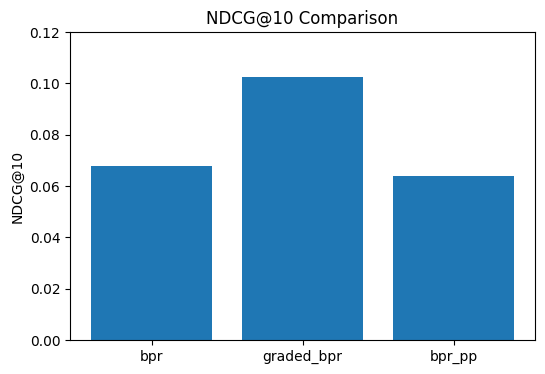

In [17]:
ndcgs = [results[m]["NDCG@10"] for m in models]

plt.figure(figsize=(6,4))
plt.bar(models, ndcgs)
plt.ylabel("NDCG@10")
plt.title("NDCG@10 Comparison")

# Zoom y-axis
plt.ylim(0.0, 0.12)

plt.show()


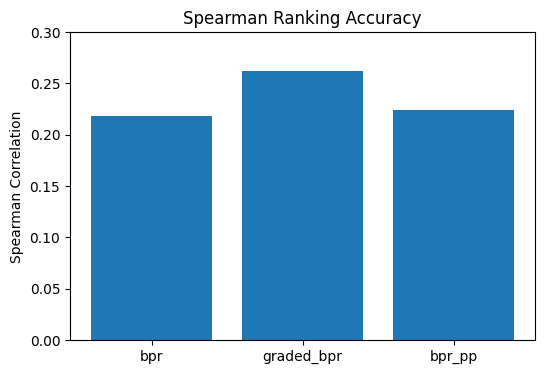

In [18]:
spearmans = [results[m]["Spearman"] for m in models]

plt.figure(figsize=(6,4))
plt.bar(models, spearmans)
plt.ylabel("Spearman Correlation")
plt.title("Spearman Ranking Accuracy")

plt.ylim(0.0, 0.3)

plt.show()
